In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
    color: black !important;
}

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
sns.set(style="whitegrid")
sns.set_context(rc={"lines.linewidth": 2})

# 在自适应调整下的水印延迟时间和乱序率的变化

该部分实验应该看disorder.csv和watermark.csv放在一起观察变化

In [5]:
def compare_adwm_perwm(path):
    waterlist = pd.read_csv(path)
    waterlist = waterlist[:-2]
    waterlist.columns = ['water', 'event']
    waterlist['skew'] = waterlist['event'] - waterlist['water']
    date_index = pd.date_range(start='2018-10-01 00:01:00',
                               periods=len(waterlist), 
                               freq='T')
    
    index = [date_index[i].hour for i in range(len(date_index))]
    
    data = {
        "adwater": waterlist['skew'].tolist(),
        "period(1000ms)": [1000]*len(index),
        "period(1300ms)": [1300]*len(index),
    }
    
    df = pd.DataFrame(data=data, index=index)
    return df

In [6]:
def draw_compare(path):
    data = compare_adwm_perwm(path)

    # plt.figure(figsize=(15, 5))
    f, ax = plt.subplots(figsize = (6, 4))
    # 设置图名称
#     ax.set_title('WaterMark Latency', fontsize=15)
    # 设置X轴 Y轴 的label
    ax.set_xlabel('Time',fontsize=13)
    ax.set_ylabel('Watermark Waiting Time(ms)',fontsize=13)

    ax.annotate('periodic wm:\n 1000ms', xy=(10, 1000),
                xytext=(10, 1100),
                arrowprops=dict(facecolor='#d0885c', headwidth=7, width=3,
                                headlength=10),
                horizontalalignment='left', verticalalignment='top')
    ax.annotate('periodic wm:\n  1300ms', xy=(0, 1300),
            xytext=(0, 1200),
            arrowprops=dict(facecolor='#6ca56f', headwidth=7, width=3,
                            headlength=10),
            horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('peak1', xy=(6, 1150),
                xytext=(6, 1250),
                arrowprops=dict(facecolor='#5472ab', headwidth=7, width=3,
                                headlength=10),
                horizontalalignment='left', verticalalignment='top')
    ax.annotate('peak2', xy=(18, 1250),
            xytext=(15, 1250),
            arrowprops=dict(facecolor='#5472ab', headwidth=7, width=3,
                            headlength=10),
            horizontalalignment='right', verticalalignment='bottom')
#     ax.set_ylim([750, 1300])
    sns.lineplot(size='event',
                 data=data)
    plt.savefig('ad-bike.pdf',bbox_inches='tight',format='pdf')
    plt.show()

## 自适应水印的水印延迟时间调整

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


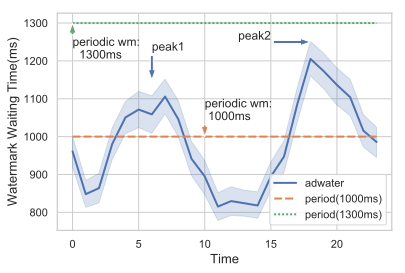

In [7]:
draw_compare('./adwater/20181001AW60/water.csv')

## 各个参数对比

In [288]:
Paths = [
            "./periodic/20181001P0W60/",
            "./periodic/20181001P0.5W60/",
            "./periodic/20181001P1W60/",
            "./periodic/20181001P1.5W60/",
            "./periodic/20181001P2W60/"
           ]
WaterPaths = [path+"water.csv" for path in Paths]
TimePaths = [path+"timelatency.csv" for path in Paths]

In [289]:
def get_drop_latency(wm, latency, threshold):
    """
        params: wm 水印和事件的映射关系 哪一个事件时间产生了水印
                latency: 窗口被哪个水印触发
        return dict {
            "drop": 真实被丢弃的概率(一般不用),
            "late": 迟到率,
            "avg_wait": 每个窗口的平均等待时间
            "pre_win_wait": 用来具体记录每个窗口的等待时间
        }
    """
    wm = pd.read_csv(wm)
    latency = pd.read_csv(latency)
    wm.columns = ["watermark", "ts"]
    
    # drop1是真正丢的数据
    drop1 = wm[-1:].iloc[0]['watermark']/wm[-1:].iloc[0]['ts']
    # drop2是默认迟到的数据
    drop2 = wm[-2:-1].iloc[0]['watermark']/wm[-2:-1].iloc[0]['ts']
#     print(wm[-2:-1], drop2)
    latency.columns = ["watermark", "window_end"]
    latency = latency.set_index("watermark")
    wm = wm.set_index("watermark")
    res = latency.join(wm, how='inner')
    res = res.reset_index(drop = True)
    
    all_wait = 0
    pre_win_wait = []
    for index, row in res.iterrows():
        if row['ts'] - row['window_end'] > threshold+6000:
            row['ts']  = row['window_end'] + threshold
        pre_win_wait.append(row['ts'] - row['window_end'])
        all_wait += row['ts'] - row['window_end']
    avg_wait = all_wait/len(res)
    
    return dict(drop=drop1, late=drop2, avg_wait=avg_wait, pre_win_wait=pre_win_wait)

In [290]:
def list_params_diff_latecny(WaterPaths, TimePaths):
    index = [0,500,1000, 1500, 2000]
    later_rate, avg_win_wait = [], []
    for i in range(len(WaterPaths)):
        water = WaterPaths[i]
        time = TimePaths[i]
        res = get_drop_latency(water, time, index[i])
        later_rate.append(res['late'])
        avg_win_wait.append(res['avg_wait'])
    data = {
        'later_rate': later_rate,
        'avg_win_wait': avg_win_wait
    }
    df = pd.DataFrame(data, index=index)
    return df

## 不同延迟下的迟到率和平均窗口等待时间

In [291]:
com = list_params_diff_latecny(WaterPaths, TimePaths)

In [292]:
com

,later_rate,avg_win_wait
0,0.480708,1244.935532
500,0.373897,1775.500000
1000,0.286769,2236.641679
1500,0.222758,2750.259370
2000,0.177758,3282.474513


## 自适应窗口的迟到率和平均等待时间

In [293]:
a = get_drop_latency('./adwater/20181001AW60/water.csv', './adwater/20181001AW60/timelatency.csv', 1000)
a['late'], a['avg_wait']

(0.28017036061531564, 2150.6304347826085)

### 画图展示

In [294]:
later, wait = com['later_rate'], com['avg_win_wait']

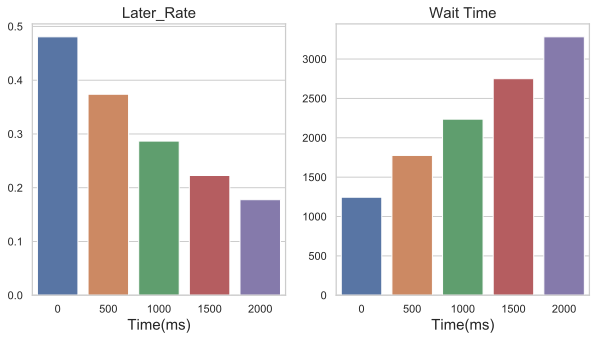

In [295]:
f, ax = plt.subplots(1,2, figsize = (10, 5))
# 设置图名称
ax[0].set_title('Later_Rate', fontsize=15)
# 设置X轴 Y轴 的label
ax[0].set_xlabel('Time(ms)',fontsize=15)
# ax1 = ax.twinx()
ax[1].set_title('Wait Time', fontsize=15)
# 设置X轴 Y轴 的label
ax[1].set_xlabel('Time(ms)',fontsize=15)
sns.barplot(x=later.index, y=later.tolist(), ax=ax[0])
sns.barplot(x=wait.index, y=wait.tolist(), ax=ax[1])

## 乱序率变化 只要保证在较低水平就可

In [86]:
lateEvent = pd.read_csv('./adwater/20181001AW60/disorder.csv')
lateEvent.columns = ["window_end", "late_event", "all"]
lateEvent['rate'] = lateEvent['late_event']/lateEvent['all']

In [87]:
date_index = pd.date_range(start='2018-10-01 00:01:00',
                           periods=len(lateEvent), 
                           freq='T')
index = [date_index[i].hour for i in range(len(date_index))]

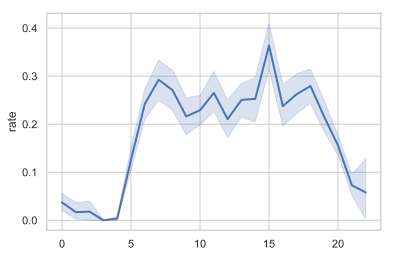

In [88]:
sns.lineplot(x=index, y=lateEvent['rate'])